# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


Transforms.compose-Composes several transforms together.
ToTensor()-Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor
Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    or if the numpy.ndarray has dtype = np.uint8
Normalize- Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]
    
Resize-Resize the input PIL Image to the given size.
CenterCrop-Crops the given PIL Image at the center.
Pad-Pad the given PIL Image on all sides with the given "pad" value
RandomTransforms-Base class for a list of transformations with randomness


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# The model
Let's start with the model we first saw

In [0]:
#defining the network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05), # output_size = 26
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05), # output_size = 24
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 22
            nn.MaxPool2d(2, 2)# output_size = 11
            
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)# output_size = 11

        ) 
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 9
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)# output_size = 7
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),#output_size = 5
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 5
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False)
            
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
      
        x = x.view(-1, 10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
#without l1 and l2
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:

from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9,weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.024565933272242546 Batch_id=468 Accuracy=93.30: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.007481416221708059 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.027916179969906807 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.04718773439526558 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.010103334672749043 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.04345237836241722 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.05333409830927849 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.042625218629837036 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.09411271661520004 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.022924110293388367 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.011661559343338013 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.009341229684650898 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.12435332685709 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.07377079874277115 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.031726013869047165 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.020684346556663513 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.006783018354326487 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.028948748484253883 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.03557027876377106 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.001609697937965393 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.006801227573305368 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.011821438558399677 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.11380655318498611 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.028803130611777306 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.005568111781030893 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.06351491808891296 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.020466050133109093 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 27


Loss=0.022290239110589027 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.03060346283018589 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.05155032500624657 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.003432636382058263 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 31


Loss=0.004340469837188721 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.0686267539858818 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.009626801125705242 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 34


Loss=0.012537375092506409 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.0751328095793724 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 36


Loss=0.003673036815598607 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.011368955485522747 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 38


Loss=0.037769097834825516 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.006281624082475901 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]



Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

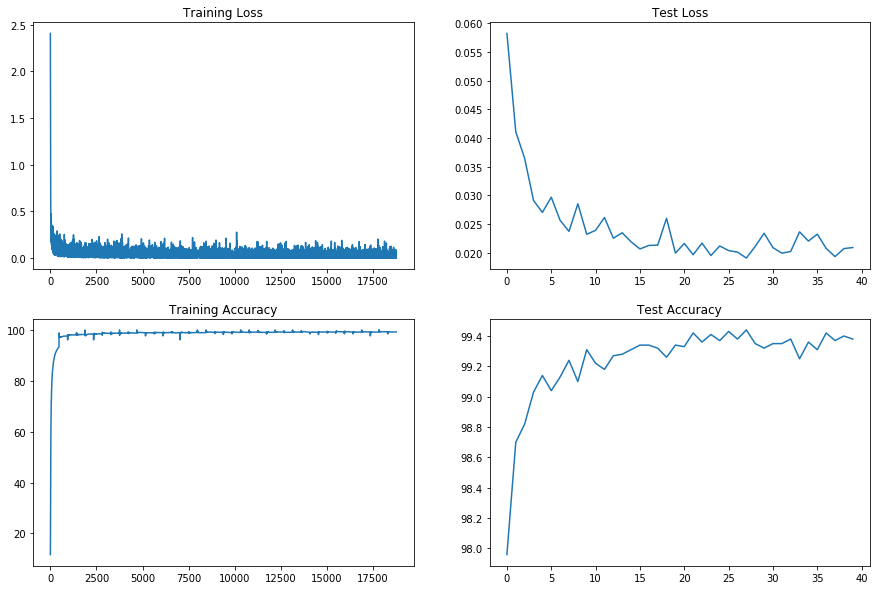

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
#with l2
from tqdm import tqdm

train_losses1 = []
test_losses1 = []
train_acc1 = []
test_acc1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc1.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc1.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9,weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.10420208424329758 Batch_id=468 Accuracy=92.72: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.1436634063720703 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.15153388679027557 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.04996111989021301 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.05122924968600273 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.011909360997378826 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.025366991758346558 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.08637594431638718 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.02790222503244877 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.06032802164554596 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9839/10000 (98.39%)

EPOCH: 10


Loss=0.16174587607383728 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.10982444137334824 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.04809604585170746 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.04578743502497673 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

EPOCH: 14


Loss=0.06083523854613304 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9894/10000 (98.94%)

EPOCH: 15


Loss=0.07792086154222488 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9895/10000 (98.95%)

EPOCH: 16


Loss=0.05095610022544861 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9877/10000 (98.77%)

EPOCH: 17


Loss=0.09181683510541916 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.06775497645139694 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9878/10000 (98.78%)

EPOCH: 19


Loss=0.036250434815883636 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Loss=0.0378890223801136 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9918/10000 (99.18%)

EPOCH: 21


Loss=0.01141221821308136 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9911/10000 (99.11%)

EPOCH: 22


Loss=0.032257355749607086 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9883/10000 (98.83%)

EPOCH: 23


Loss=0.06661329418420792 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9907/10000 (99.07%)

EPOCH: 24


Loss=0.013643264770507812 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 25


Loss=0.1655186265707016 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 26


Loss=0.09333368390798569 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9913/10000 (99.13%)

EPOCH: 27


Loss=0.04417992755770683 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9920/10000 (99.20%)

EPOCH: 28


Loss=0.05406506359577179 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9862/10000 (98.62%)

EPOCH: 29


Loss=0.03108007274568081 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)

EPOCH: 30


Loss=0.010305146686732769 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.10%)

EPOCH: 31


Loss=0.02415403164923191 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 32


Loss=0.10115638375282288 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9898/10000 (98.98%)

EPOCH: 33


Loss=0.04760937765240669 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 36.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9887/10000 (98.87%)

EPOCH: 34


Loss=0.05185428634285927 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 36.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9899/10000 (98.99%)

EPOCH: 35


Loss=0.03709682077169418 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 36


Loss=0.06465011090040207 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9885/10000 (98.85%)

EPOCH: 37


Loss=0.025427082553505898 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 38


Loss=0.03394828736782074 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 39


Loss=0.01555249560624361 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]



Test set: Average loss: 0.0400, Accuracy: 9876/10000 (98.76%)



Text(0.5, 1.0, 'Test Accuracy')

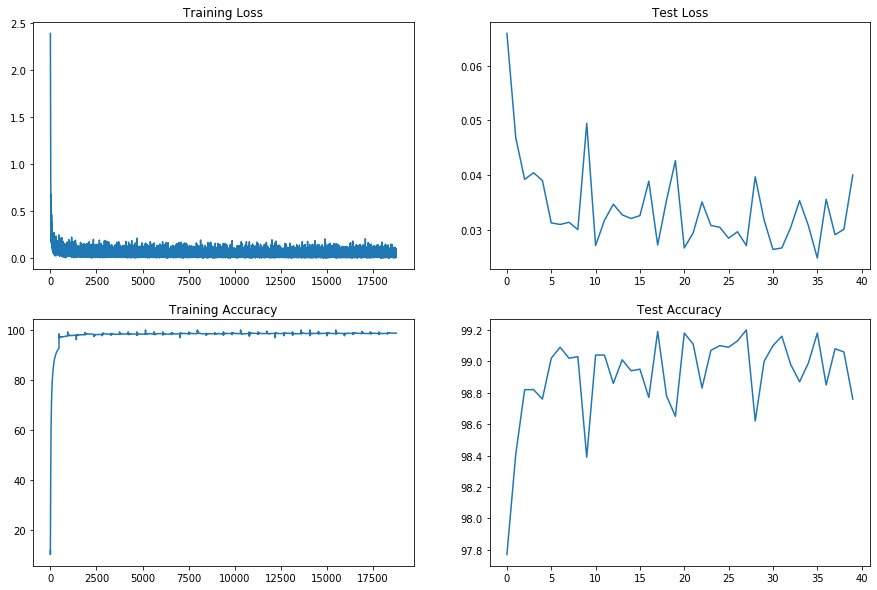

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

In [0]:
#with l1
from tqdm import tqdm

train_losses2 = []
test_losses2 = []
train_acc2 = []
test_acc2= []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zero_vector)

    factor = 0.0005
    loss += factor * reg_loss
    train_losses2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc2.append(100. * correct / len(test_loader.dataset))

In [14]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)



EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3473174273967743 Batch_id=468 Accuracy=93.66: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.27253302931785583 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9746/10000 (97.46%)

EPOCH: 2


Loss=0.2061912566423416 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0987, Accuracy: 9676/10000 (96.76%)

EPOCH: 3


Loss=0.3513505160808563 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0895, Accuracy: 9702/10000 (97.02%)

EPOCH: 4


Loss=0.30631476640701294 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9825/10000 (98.25%)

EPOCH: 5


Loss=0.21287088096141815 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.2179758995771408 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.26647448539733887 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9811/10000 (98.11%)

EPOCH: 8


Loss=0.2868140935897827 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9819/10000 (98.19%)

EPOCH: 9


Loss=0.23917561769485474 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9793/10000 (97.93%)

EPOCH: 10


Loss=0.19350238144397736 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0831, Accuracy: 9735/10000 (97.35%)

EPOCH: 11


Loss=0.29440492391586304 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:17<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9790/10000 (97.90%)

EPOCH: 12


Loss=0.2596852779388428 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:18<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 9769/10000 (97.69%)

EPOCH: 13


Loss=0.19767706096172333 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9800/10000 (98.00%)

EPOCH: 14


Loss=0.2607661783695221 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9845/10000 (98.45%)

EPOCH: 15


Loss=0.184499591588974 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9794/10000 (97.94%)

EPOCH: 16


Loss=0.270795077085495 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9768/10000 (97.68%)

EPOCH: 17


Loss=0.20483575761318207 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9847/10000 (98.47%)

EPOCH: 18


Loss=0.22065645456314087 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:17<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0781, Accuracy: 9742/10000 (97.42%)

EPOCH: 19


Loss=0.22789686918258667 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9712/10000 (97.12%)

EPOCH: 20


Loss=0.21623528003692627 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9816/10000 (98.16%)

EPOCH: 21


Loss=0.24036571383476257 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:16<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9677/10000 (96.77%)

EPOCH: 22


Loss=0.20921704173088074 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9831/10000 (98.31%)

EPOCH: 23


Loss=0.18596722185611725 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9821/10000 (98.21%)

EPOCH: 24


Loss=0.2059655785560608 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9835/10000 (98.35%)

EPOCH: 25


Loss=0.3612551689147949 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0814, Accuracy: 9742/10000 (97.42%)

EPOCH: 26


Loss=0.22062426805496216 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9783/10000 (97.83%)

EPOCH: 27


Loss=0.22296053171157837 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9804/10000 (98.04%)

EPOCH: 28


Loss=0.22719377279281616 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:16<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9812/10000 (98.12%)

EPOCH: 29


Loss=0.22357973456382751 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2091, Accuracy: 9386/10000 (93.86%)

EPOCH: 30


Loss=0.29122817516326904 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9851/10000 (98.51%)

EPOCH: 31


Loss=0.2962851822376251 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1063, Accuracy: 9669/10000 (96.69%)

EPOCH: 32


Loss=0.22951781749725342 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9685/10000 (96.85%)

EPOCH: 33


Loss=0.22962743043899536 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9855/10000 (98.55%)

EPOCH: 34


Loss=0.18945647776126862 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9789/10000 (97.89%)

EPOCH: 35


Loss=0.1687193661928177 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9875/10000 (98.75%)

EPOCH: 36


Loss=0.23884868621826172 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:16<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9828/10000 (98.28%)

EPOCH: 37


Loss=0.316008985042572 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9846/10000 (98.46%)

EPOCH: 38


Loss=0.1898852437734604 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9824/10000 (98.24%)

EPOCH: 39


Loss=0.24092569947242737 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0612, Accuracy: 9808/10000 (98.08%)



Text(0.5, 1.0, 'Test Accuracy')

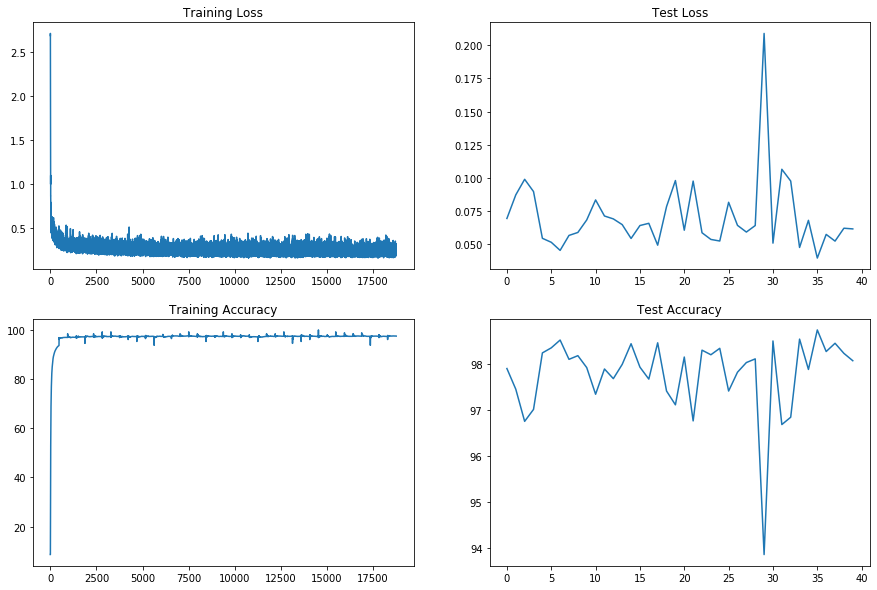

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc2)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc2)
axs[1, 1].set_title("Test Accuracy")

In [0]:

#with l1 and l2
from tqdm import tqdm

train_losses3 = []
test_losses3 = []
train_acc3 = []
test_acc3= []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zero_vector)

    factor = 0.0005
    loss += factor * reg_loss
    train_losses3.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc3.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses3.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc3.append(100. * correct / len(test_loader.dataset))

In [17]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9,weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)



EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.34104132652282715 Batch_id=468 Accuracy=93.40: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9711/10000 (97.11%)

EPOCH: 1


Loss=0.3452252447605133 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1020, Accuracy: 9680/10000 (96.80%)

EPOCH: 2


Loss=0.2393430471420288 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Loss=0.2096332609653473 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.26289576292037964 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1334, Accuracy: 9560/10000 (95.60%)

EPOCH: 5


Loss=0.16794802248477936 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9795/10000 (97.95%)

EPOCH: 6


Loss=0.28820616006851196 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1149, Accuracy: 9634/10000 (96.34%)

EPOCH: 7


Loss=0.22796759009361267 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9854/10000 (98.54%)

EPOCH: 8


Loss=0.24600747227668762 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9838/10000 (98.38%)

EPOCH: 9


Loss=0.19795125722885132 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9708/10000 (97.08%)

EPOCH: 10


Loss=0.21328291296958923 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9756/10000 (97.56%)

EPOCH: 11


Loss=0.2428571879863739 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9787/10000 (97.87%)

EPOCH: 12


Loss=0.18832306563854218 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9857/10000 (98.57%)

EPOCH: 13


Loss=0.19567663967609406 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9734/10000 (97.34%)

EPOCH: 14


Loss=0.1935904175043106 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0781, Accuracy: 9776/10000 (97.76%)

EPOCH: 15


Loss=0.21018430590629578 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9809/10000 (98.09%)

EPOCH: 16


Loss=0.22938960790634155 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9805/10000 (98.05%)

EPOCH: 17


Loss=0.23688039183616638 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:16<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9826/10000 (98.26%)

EPOCH: 18


Loss=0.20513448119163513 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9776/10000 (97.76%)

EPOCH: 19


Loss=0.2906220555305481 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:16<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9754/10000 (97.54%)

EPOCH: 20


Loss=0.20542502403259277 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9820/10000 (98.20%)

EPOCH: 21


Loss=0.21291762590408325 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:16<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9805/10000 (98.05%)

EPOCH: 22


Loss=0.20890814065933228 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0873, Accuracy: 9744/10000 (97.44%)

EPOCH: 23


Loss=0.3921545445919037 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1145, Accuracy: 9649/10000 (96.49%)

EPOCH: 24


Loss=0.23521411418914795 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1013, Accuracy: 9700/10000 (97.00%)

EPOCH: 25


Loss=0.2514829933643341 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9819/10000 (98.19%)

EPOCH: 26


Loss=0.2119826078414917 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9807/10000 (98.07%)

EPOCH: 27


Loss=0.20668762922286987 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Accuracy: 9761/10000 (97.61%)

EPOCH: 28


Loss=0.2666626572608948 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9736/10000 (97.36%)

EPOCH: 29


Loss=0.2854190468788147 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9822/10000 (98.22%)

EPOCH: 30


Loss=0.3013661503791809 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9770/10000 (97.70%)

EPOCH: 31


Loss=0.2382068932056427 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9838/10000 (98.38%)

EPOCH: 32


Loss=0.24347248673439026 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9737/10000 (97.37%)

EPOCH: 33


Loss=0.19470447301864624 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9838/10000 (98.38%)

EPOCH: 34


Loss=0.19129729270935059 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9795/10000 (97.95%)

EPOCH: 35


Loss=0.20704016089439392 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0619, Accuracy: 9807/10000 (98.07%)

EPOCH: 36


Loss=0.21842607855796814 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9779/10000 (97.79%)

EPOCH: 37


Loss=0.20253059267997742 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1873, Accuracy: 9409/10000 (94.09%)

EPOCH: 38


Loss=0.18088291585445404 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9833/10000 (98.33%)

EPOCH: 39


Loss=0.20615997910499573 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]



Test set: Average loss: 0.1118, Accuracy: 9659/10000 (96.59%)



Text(0.5, 1.0, 'Test Accuracy')

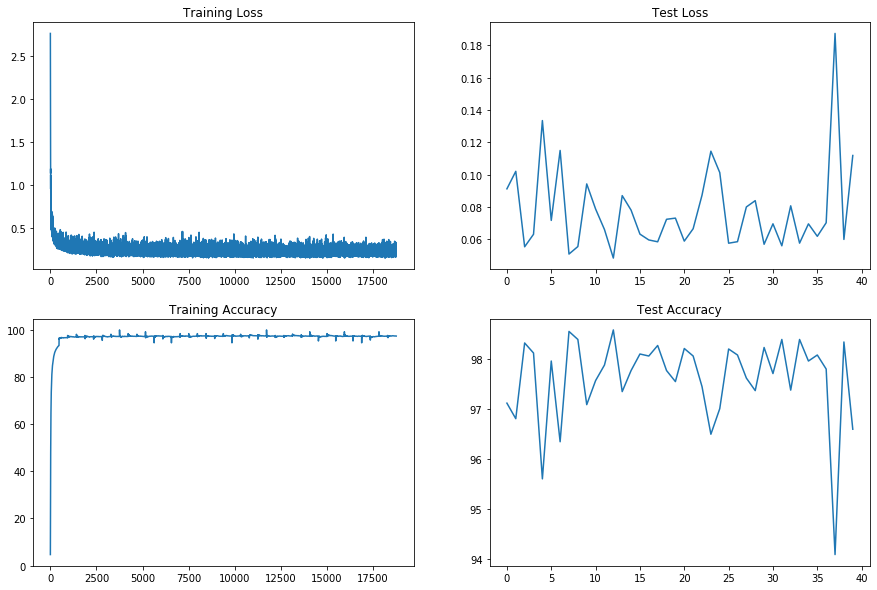

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses3)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc3)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses3)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc3)
axs[1, 1].set_title("Test Accuracy")

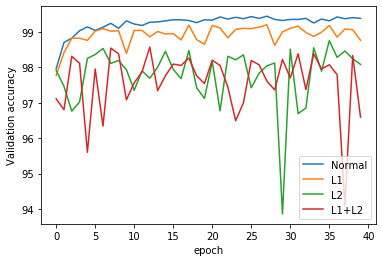

In [23]:
plt.plot(test_acc)
plt.plot(test_acc1)
plt.plot(test_acc2)
plt.plot(test_acc3)

plt.legend(['Normal', 'L1', 'L2', 'L1+L2'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Validation accuracy')
plt.savefig('accuracy graph')
plt.show()


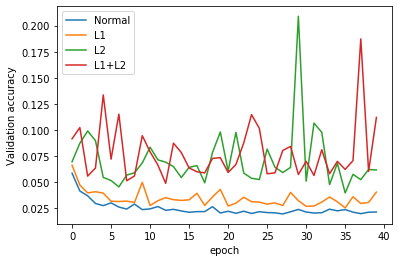

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(test_losses)
plt.plot(test_losses1)
plt.plot(test_losses2)
plt.plot(test_losses3)

plt.legend(['Normal', 'L1', 'L2', 'L1+L2'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('Validation accuracy')

plt.show()
plt.savefig('losses graph')

In [0]:
#finding out wrongly predicted values for l1
from tqdm import tqdm

train_losses2 = []
test_losses2 = []
train_acc2 = []
test_acc2= []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      zero_vector=torch.rand_like(param)*0
      reg_loss += l1_crit(param,zero_vector)

    factor = 0.0005
    loss += factor * reg_loss
    train_losses2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    pred1=[]
    tar1=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            tar2=target.numpy()
            tar1.append(tar2)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred2=pred.numpy()
            pred1.append(pred2)
            correct += pred.eq(target.view_as(pred)).sum().item()
    # print(target,'target')
    # print(correct,'correct')
    # print(pred1,'prediction1')
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc2.append(100. * correct / len(test_loader.dataset))
    return tar1,pred1

In [91]:
u,j=test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.1186, Accuracy: 9650/10000 (96.50%)



In [92]:
import pandas as pd
import numpy as np
import functools 
j=np.array(j)
m=j.ravel()
predi=[]
for i in range(m.shape[0]):
  predi.extend(list(m[i].ravel()))
len(predi)


10000

In [93]:
u=np.array(u)
p=u.ravel()
actual=[]
for i in range(p.shape[0]):
  actual.extend(list(p[i].ravel()))
len(actual)


10000

In [0]:
valid=pd.DataFrame(actual,columns=['actual'])
valid['pred']=predi
valid['validation_l1'] = np.where(valid['actual']==valid['pred'], 'True', 'False')
valid_l1=valid[valid['validation_l1']=='False']
valid_l1.to_csv('validation_11.csv')

In [0]:
from google.colab import files
valid_l1.to_csv('validation_11.csv') 
files.download('validation_11.csv')

In [86]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)



EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=2.6849496364593506 Batch_id=0 Accuracy=10.94:   0%|          | 1/938 [00:00<02:06,  7.39it/s]

EPOCH: 0


Loss=0.35923781991004944 Batch_id=937 Accuracy=93.61: 100%|██████████| 938/938 [02:01<00:00,  7.74it/s]



Test set: Average loss: 0.1186, Accuracy: 9650/10000 (96.50%)



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


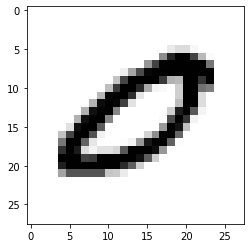

In [38]:
#visualising the test data
test_data = test.test_data
test_data = test.transform(test_data.numpy())
dataiter = iter(test_loader)
images, labels = dataiter.next()
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

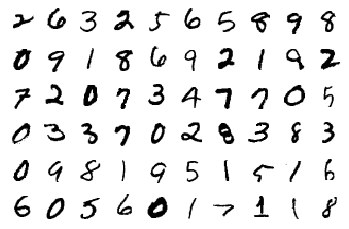

In [39]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
#finding out wrongly predicted values for l2
from tqdm import tqdm

train_losses1 = []
test_losses1 = []
train_acc1 = []
test_acc1 = []

def train1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc1.append(100*correct/processed)

def test1(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    pred1=[]
    tar1=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            tar2=target.numpy()
            tar1.append(tar2)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred2=pred.numpy()
            pred1.append(pred2)
            correct += pred.eq(target.view_as(pred)).sum().item()
    # print(target,'target')
    # print(correct,'correct')
    # print(pred1,'prediction1')
    test_loss /= len(test_loader.dataset)
    test_losses1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc1.append(100. * correct / len(test_loader.dataset))
    return tar1,pred1

In [12]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0335, momentum=0.9,weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)



EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train1(model, device, train_loader, optimizer, epoch)
    test1(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.390214204788208 Batch_id=0 Accuracy=15.62:   0%|          | 1/938 [00:00<02:08,  7.30it/s]

EPOCH: 0


Loss=0.1705399453639984 Batch_id=937 Accuracy=94.14: 100%|██████████| 938/938 [01:59<00:00,  7.86it/s]



Test set: Average loss: 0.0515, Accuracy: 9832/10000 (98.32%)



In [13]:
w,q=test1(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.0515, Accuracy: 9832/10000 (98.32%)



In [14]:
import pandas as pd
import numpy as np
import functools 
q=np.array(q)
m=q.ravel()
predi=[]
for i in range(m.shape[0]):
  predi.extend(list(m[i].ravel()))
len(predi)


10000

In [15]:
w=np.array(w)
p=w.ravel()
actual=[]
for i in range(p.shape[0]):
  actual.extend(list(p[i].ravel()))
len(actual)

10000

In [20]:
valid=pd.DataFrame(actual,columns=['actual'])
valid['pred']=predi
valid['validation_l2'] = np.where(valid['actual']==valid['pred'], 'True', 'False')
validation_l2=valid[valid['validation_l2']=='False']
#valid_l1.to_csv('validation_11.csv')
validation_l2.shape

(168, 3)

In [0]:
from google.colab import files
validation_l2.to_csv('validation_l2.csv') 
files.download('validation_l2.csv')